In [12]:
from jax import numpy as jnp, random, lax, jit, grad, scipy as jsp, value_and_grad, Array, vmap
import pandas as pd
import numpy as np

In [13]:
def safe_sqrt(x: Array) -> Array:
    """Gradient safe sqrt function; will produce 0 instead of NaN

    Args:
        x: Input value

    Returns:
        NaN-free sqrt values
    """
    xsqrt = jnp.sqrt(jnp.where(x > 0.0, x, 1.0))
    xsqrt = jnp.where(x <= 0.0, 0.0, xsqrt)
    return xsqrt

In [14]:
def bproc(k, initv, p, recovery_rate, N=100):

    q = 1.0 - p

    def bstep(carry, i):
        k, S, I, R = carry

        k_next, k_i, k_r = random.split(k,3)
        step = (S/(S+I+R)) * (random.normal(k_i) * safe_sqrt(I*p*q) + I*p)

        step = jnp.where(step<0.0, 0.0, step)
        step = jnp.where(step>S, S, step)

        R_step = (random.normal(k_r) * safe_sqrt(I*recovery_rate*(1.0-recovery_rate)) + I*recovery_rate)
        R_step = jnp.where(R_step<0.0, 0.0, R_step)
        R_step = jnp.where(R_step>I, I, R_step)

        #R_step = recovery_rate
        new_R = R + R_step
        new_I = I + step - R_step
        new_I = jnp.where(new_I < 1.0, 0.0, new_I)
        new_S = S - step
        

        return (k_next, new_S, new_I, new_R), (new_S, new_I, new_R, step)

    return lax.scan(bstep, (k, *initv), length=N)[1]

In [15]:
contact_rate = 0.2
recovery_rate = 0.1

k = random.PRNGKey(1)

obs_res = bproc(k, (1000.0,5.0,0.0), contact_rate, recovery_rate)

In [21]:
def random_walk(mean, sd, k, N) -> Array:
    """Random gaussian walk

    Args:
        mean: Gaussian mean
        sd: Gaussian sd
        k: Jax PRNGKey
        N: Number of timesteps

    Returns:
        Array of random walk values
    """
    return jnp.cumsum(random.normal(k,(N,)) * sd + mean)

def norm_to_range(x, low, high):
    x = x - np.min(x)
    x = x / np.max(x)
    x = x * (high-low)
    x = x + low
    return x

In [23]:
detection_rate = norm_to_range(random_walk(0.0, 0.1, k, 100),0.15,0.25)

<Axes: >

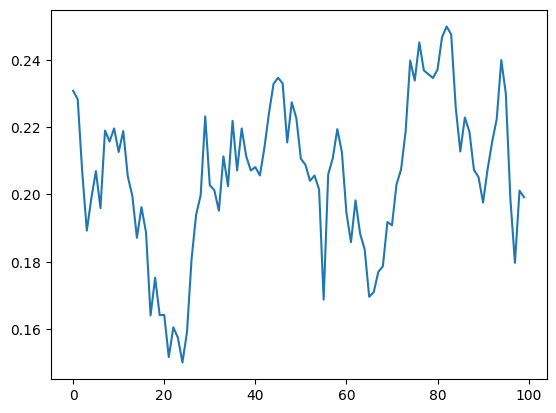

In [32]:
pd.Series(detection_rate).plot()

<Axes: >

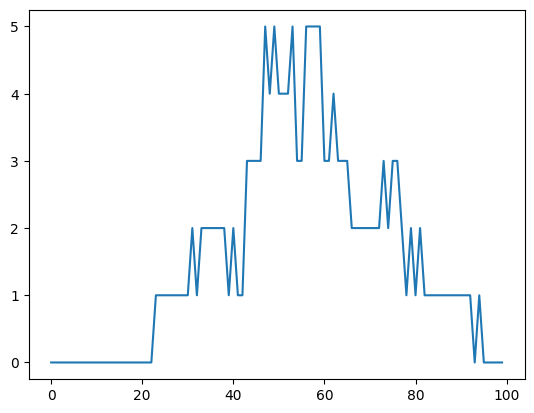

In [24]:
np.round(pd.Series(obs_res[3] * detection_rate)).plot()

In [25]:
bprocv = jit(vmap(bproc, [0,0,None,None,None]), static_argnums=[4])
resv = bprocv(random.split(random.PRNGKey(15),256),jnp.vstack([jnp.array((1000.0,5.0,0.0))]*256),contact_rate,recovery_rate,200)

<Axes: >

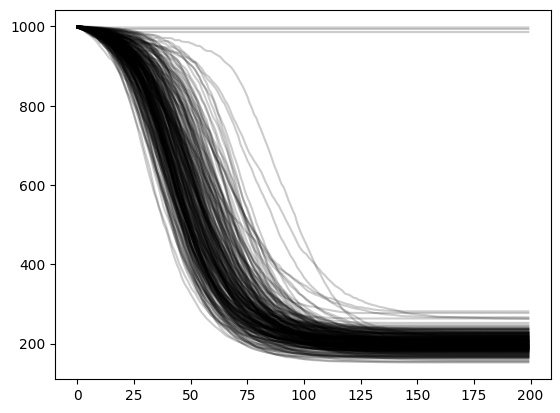

In [26]:
# S
pd.DataFrame(resv[0]).T.plot(legend=None, color="#00000033")

<Axes: >

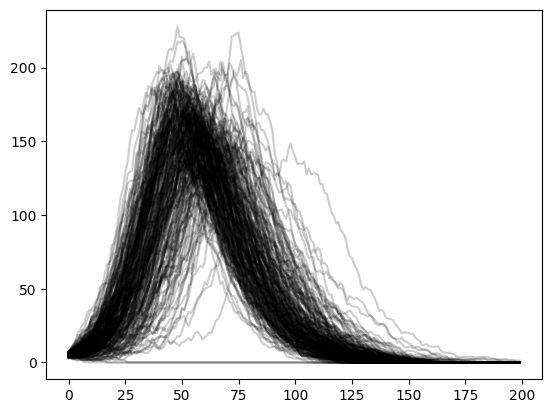

In [29]:
# I
pd.DataFrame(resv[1]).T.plot(legend=None, color="#00000033")

<Axes: >

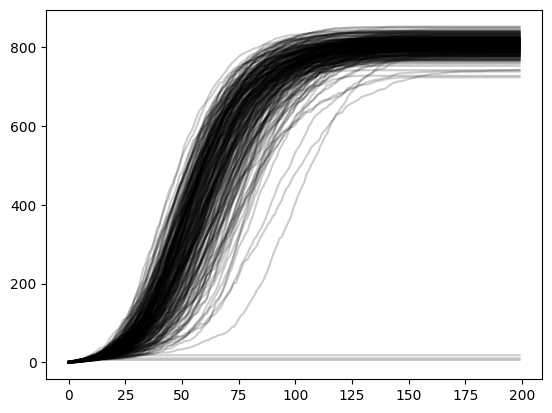

In [30]:
# R
pd.DataFrame(resv[2]).T.plot(legend=None, color="#00000033")

<Axes: >

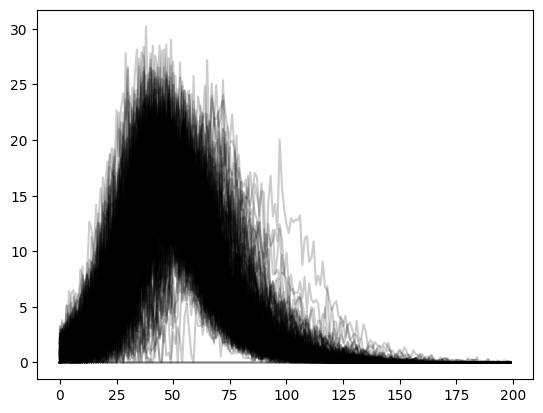

In [31]:
# New infections
pd.DataFrame(resv[3]).T.plot(legend=None, color="#00000033")